# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [1]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [2]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

  0%|          | 0/9 [00:00<?, ?it/s]

<_io.BufferedReader name='data/Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 11%|█         | 1/9 [00:00<00:04,  1.80it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


 22%|██▏       | 2/9 [00:00<00:02,  2.38it/s]

<_io.BufferedReader name='data/Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data/ZHAW_Zitierleitfaden_DE.pdf'>


 44%|████▍     | 4/9 [00:01<00:02,  2.17it/s]

<_io.BufferedReader name='data/Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 56%|█████▌    | 5/9 [00:02<00:01,  2.28it/s]

<_io.BufferedReader name='data/05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>
<_io.BufferedReader name='data/Schwerpunktthemen_fuer_Studenten.pdf'>


 78%|███████▊  | 7/9 [00:02<00:00,  3.35it/s]

<_io.BufferedReader name='data/02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>


 89%|████████▉ | 8/9 [00:02<00:00,  3.28it/s]

<_io.BufferedReader name='data/W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


'Z-MB-Merkblatt Verwendung von  \ngenerativer KI bei'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [3]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [4]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 62
Preview of the first chunk: Z-MB-Merkblatt Verwendung von  
generativer KI bei Arbeiten  
Version:  1.2.0 gültig ab:  01.03.2025   Seite 1 von 5 
 Rektorat  
Ressort Bildung  
Verwendung von generativer KI bei Arbeiten  
Dieses 


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [5]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [6]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 254
Z-MB-Merkblatt Verwendung von generativer KI bei Arbeiten Version: 1.2.0 gültig ab: 01.03.2025 Seite 1 von 5 Rektorat Ressort Bildung Verwendung von generativer KI bei Arbeiten Dieses Merkblatt basiert auf : − Richtlinie KI bei Leistungsnachweisen − ergänzender Anhang 1. Grundsatz Grundsätzlich gilt, dass die Verwendung von generativen KI -Tools bei Arbeiten zu de- klarieren ist. Dieses Merkblatt hilft Ihnen Schritt -für-Schritt bei der korrekten Umset- zung. 2. Pflichten im Umgang Ihre Pflichten im Umgang mit generativer KI − Sie


In [ ]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁Z', '-', 'MB', '-', 'Mer', 'k', 'blatt', '▁Verwendung', '▁von', '▁genera', 'ti', 'ver', '▁KI', '▁bei', '▁Arbeiten', '▁Version', ':', '▁1.', '2.0', '▁gültig', '▁ab', ':', '▁01.', '03.20', '25', '▁Seite', '▁1', '▁von', '▁5', '▁Rektor', 'at', '▁Res', 'sort', '▁Bildung', '▁Verwendung', '▁von', '▁genera', 'ti', 'ver', '▁KI', '▁bei', '▁Arbeiten', '▁Dieses', '▁Merk', 'blatt', '▁bas', 'iert', '▁auf', '▁:', '▁−', '▁', 'Richtlinie', '▁KI', '▁bei', '▁Leistungs', 'nach', 'weise', 'n', '▁−', '▁ergänzen', 'der', '▁An', 'hang', '▁1.', '▁Grund', 'satz', '▁Grundsätzlich', '▁gilt', ',', '▁dass', '▁die', '▁Verwendung', '▁von', '▁genera', 'tive', 'n', '▁KI', '▁-', 'Tool', 's', '▁bei', '▁Arbeiten', '▁zu', '▁de', '-', '▁klar', 'ieren', '▁ist', '.', '▁Dieses', '▁Merk', 'blatt', '▁hilft', '▁Ihnen', '▁Schritt', '▁-', 'für', '-', 'Sch', 'rit', 't', '▁bei', '▁der', '▁korrekt', 'en', '▁Um', 'set', '-', '▁', 'zung', '.', '▁2.', '▁Pflicht', 'en', '▁im', '▁Umgang', '▁Ihre', '▁Pflicht', 'en', '▁im'

: 

In [ ]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [2]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

NameError: name 'HuggingFaceEmbeddings' is not defined

## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [ ]:
d = chunk_embeddings.shape[1]
print(d)

384


In [ ]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 254


In [ ]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [ ]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

62
254


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [ ]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/254 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/254 [00:02<10:20,  2.45s/it]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/si

Projected dataset embeddings shape: (254, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [ ]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [ ]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
und Weise zu organisieren. Sie setzen sich angemessene Ziele im Lern - und Arbeitsprozess und können diese entsprechend verf olgen und reflektieren. 6. Art der Arbeit Die Bachelorarbeit kann nur als Einzelarbeit durchgeführt werden. 7. Themenbereich Die Studierenden schreiben ihre Bachelorarbeit im 


In [ ]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings: 100%|██████████| 1/1 [00:00<0

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

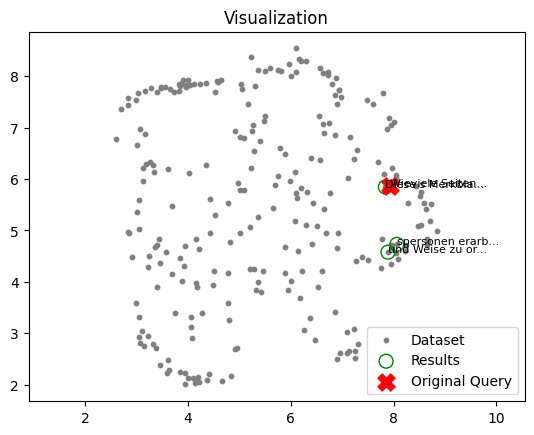

In [ ]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


In [ ]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

## Embedding-Based Semantic Retrieval

In [ ]:
# Example user query
user_query = "Was ist bei der Nutzung von KI in wissenschaftlichen Arbeiten zu beachten?"

# Encode the query using the SentenceTransformer model
user_query_embedding = model.encode([user_query], convert_to_numpy=True)

# Perform nearest-neighbor search in the FAISS index
k = 5
distances, indices = index.search(user_query_embedding, k)

# Retrieve the top-k similar text chunks
retrieved_chunks = [token_split_texts[i] for i in indices[0]]

print("Top-k retrieved chunks:")
for i, chunk in enumerate(retrieved_chunks):
    print(f"{i+1}. {chunk[:200]}...\n")

Top-k retrieved chunks:
1. zielführend noch praktikabel. Im Sinne der Eigenleistung bzw. wissenschaftlichen Integrität muss die Ver - wendung von KI jedoch bestmöglich transparent gemacht werden. Grundsätzlich gilt daher eine D...

2. Arbeit sowie zur Dokumentation der Qualität des eigenen wissenschaftlichen Wirkens, muss generell in der Einleitung zur Arbeit oder im Methodenabschnitt/ -teil beschrieben werden, wie generative KI -S...

3. kritisch reflektieren. Es soll daraus einerseits hervorgehen, in welchem Umfang gene- rative KI -Tools an der schöpferischen Leistung der Arbeit beteiligt waren und anderer- seits eine methodische Ref...

4. Einleitung [...] Schliesslich sei erwähnt, dass generative KI -Systeme bzw. KI -Tools einerseits als In- spirationsquelle und für ein initiales Brainstorming verwendet wurde n. Besonders die kritische...

5. . hierzu Reglement Digitale Prüfungen). 6.2 Verwendung generativer KI -Systeme in Arbeiten Arbeiten sind Leistungsnachweise, die im Unterschi

## LLM Prompt Construction and Query Answering

In [ ]:
import os
import requests
from dotenv import load_dotenv

# .env laden
load_dotenv()

# API-Key aus Umgebungsvariable holen
api_key = os.getenv("GROQ_API_KEY")

# Sicherstellen, dass Key geladen wurde
if not api_key:
    print("Fehler: Kein API-Key gefunden. Bitte überprüfe deine .env-Datei.")
    exit()

# Anfrage vorbereiten
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# Eingabe für das Modell (du kannst das prompt dynamisch ändern)
user_message = "Sag mir etwas Interessantes über KI."

data = {
    "model": "llama3-8b-8192",  # Oder: llama3-70b-8192
    "messages": [{"role": "user", "content": user_message}],
    "max_tokens": 200,
    "temperature": 0.2
}

# POST-Anfrage an Groq senden
response = requests.post(
    "https://api.groq.com/openai/v1/chat/completions",
    headers=headers,
    json=data
)

# Ausgabe
if response.status_code == 200:
    result = response.json()
    print("\nAntwort des LLM:\n")
    print(result["choices"][0]["message"]["content"].strip())
else:
    print(f"\n Fehler beim API-Aufruf: {response.status_code}")
    print(response.text)


Antwort des LLM:

Here's something interesting about AI:

**Did you know that AI has been used to create art that is indistinguishable from human-created art?**

In 2018, an AI system called "Generative Adversarial Networks" (GAN) was used to create a portrait of a person that was so realistic, it was mistaken for a real photograph by many people. The portrait was created by feeding the AI system a dataset of images of faces and then training it to generate new images that looked similar.

This technology has since been used to create a wide range of artworks, including paintings, sculptures, and even music. In fact, some art critics have argued that AI-generated art is just as valuable and meaningful as art created by humans.

**But here's the really interesting part:** the AI system doesn't just create art - it also learns from the art it creates. For example, if the AI system generates a portrait of a person with a certain expression, it can then use that expression


## User Query Execution

In [ ]:
import os
import requests
from dotenv import load_dotenv

# .env-Datei laden (enthält GROQ_API_KEY)
load_dotenv()
api_key = os.getenv("GROQ_API_KEY")

# Sicherstellen, dass der API-Key geladen wurde
if not api_key:
    print("Kein API-Key gefunden. Stelle sicher, dass deine .env-Datei korrekt ist.")
    exit()

# Header für die API-Anfrage
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

# Beispiel-Kontext (retrieved_chunks)
retrieved_chunks = (
    "Asthma ist eine chronische Entzündung der Atemwege. "
    "Typische Auslöser sind Allergene, kalte Luft oder körperliche Anstrengung. "
    "Die Diagnose erfolgt durch Lungenfunktionstests wie Spirometrie und Messung der Peak-Flow-Werte."
)

# Beispiel-Frage
example_query = "What is the most important factor in diagnosing asthma?"

# Prompt vorbereiten
prompt = f"""Nutze den folgenden Kontext, um die Frage zu beantworten:

{retrieved_chunks}

Frage: {example_query}
Antwort:"""

# Anfrage-Daten für Groq LLM
data = {
    "model": "llama3-8b-8192",  # Alternativ: "llama3-70b-8192"
    "messages": [{"role": "user", "content": prompt}],
    "max_tokens": 300,
    "temperature": 0.3
}

# POST-Anfrage an die Groq-API
response = requests.post(
    "https://api.groq.com/openai/v1/chat/completions",
    headers=headers,
    json=data
)

# Antwort anzeigen
if response.status_code == 200:
    result = response.json()
    answer = result["choices"][0]["message"]["content"].strip()

    print("\nAntwort des Sprachmodells\n" + "="*35)
    print(f"\nFrage:\n→ {example_query}\n")
    print("Kontext (vereinfacht):")
    print(f"{retrieved_chunks}\n")
    print("Antwort:")
    print(f"{answer}\n")
else:
    print(f"\nFehler beim API-Aufruf: {response.status_code}")
    print(response.text)



Antwort des Sprachmodells

Frage:
→ What is the most important factor in diagnosing asthma?

Kontext (vereinfacht):
Asthma ist eine chronische Entzündung der Atemwege. Typische Auslöser sind Allergene, kalte Luft oder körperliche Anstrengung. Die Diagnose erfolgt durch Lungenfunktionstests wie Spirometrie und Messung der Peak-Flow-Werte.

Antwort:
According to the given context, the most important factor in diagnosing asthma is a combination of Lungenfunktionstests, specifically Spirometrie and Messung der Peak-Flow-Werte (measurement of peak flow values).

